In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


# Section 1.1.1
# Acquiring Data
The following section sets up code to automatically acquire data from Kaggle and Reddit. This includes downloading prebuilt datasets and generating our own dataset. Later the datasets will be joined (merged), cleaned and analyzed.

## Tools Used
Below is the list of modules and tools we'll be using to acquire the data:

1. **Python Standard Libraries**: `os` for operating system dependent functionality, like reading or writing to the file system.

2. **Kaggle**: Kaggle is a platform that hosts numerous datasets and we'll be using the Kaggle API to download the required datasets.

3. **PRAW (Python Reddit API Wrapper)**: This will be used to interact with Reddit's API to generate our own dataset.

4. **json** for parsing and generating JSON data format, which is typically used to handle API requests and responses.

5. **pandas** for data manipulation and analysis.

## Steps

1. **Setting Up Project Directories**: This involves creating meaningful directories to organize our project. Using Python's `os` module, we can create directories for holding our raw datasets, processed datasets, and outputs.

2. **Acquiring Authentication Keys and Tokens**: To interact with Kaggle's and Reddit's API, we'll need to acquire authentication keys and tokens. This usually involves creating an account on the platform, registering for API access, and then generating the keys.

3. **Downloading Datasets**: Once we have our authentication keys, we can use them to access the APIs and download our datasets. This will involve using the `kaggle` API to download our Kaggle datasets, and using `PRAW` to interface with Reddit and generate our custom dataset.

4. **Loading and Merging Datasets**: After acquiring all necessary data, we'll load them into `pandas` DataFrames. If necessary, we'll merge multiple datasets into a single DataFrame for more efficient analysis.

5. **Data Cleaning**: We'll process our datasets to remove any irrelevant data, handle missing or null values, and generally prepare the data for further analysis. This typically involves using various `pandas` methods to manipulate the DataFrames.

By following these steps, we can ensure that we have a well-structured project setup, along with the necessary data for our analysis.

In [ ]:
# placing authentication tokens in the correct directory
import os
os.makedirs('/root/.kaggle', exist_ok=True)
# copies the API key to the correct directory for automatically fetching data
!cp '/content/drive/MyDrive/DSCI511/kaggle.json' /root/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/DSCI511/kaggle.json': No such file or directory


In [ ]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import os
# make a folder to hold the datasets-kaggle
!mkdir '/content/drive/MyDrive/DSCI511/kaggle-datasets'
# Directory for reddit datasets
!mkdir '/content/drive/MyDrive/DSCI511/reddit-datasets'



mkdir: cannot create directory ‘/content/drive/MyDrive/DSCI511/kaggle-datasets’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/DSCI511/reddit-datasets’: File exists


In [ ]:
# Authenticate with the Kaggle API
api = KaggleApi()
api.authenticate()

## 1.1.2 This section shows our code to download a prebuilt Kaggle dataset which has labels for different mental health conditions including
- PTSD
- Anxiety
- Depression
- Survivorsofabuse
and several others

In [ ]:
# Downloading dataset from kaggle
os.chdir("/content/drive/MyDrive/DSCI511/kaggle-datasets") # change working directory
files_array = ["dreaddit-test.csv", "dreaddit-train.csv"]
for file in files_array:
  api.dataset_download_file('ruchi798/stress-analysis-in-social-media',file_name=file)



In [ ]:
import zipfile
# running unzip to extract CSV file from dataset
zip_path = '/content/drive/MyDrive/DSCI511/kaggle-datasets/dreaddit-train.csv.zip'
output_dir = '/content/drive/MyDrive/DSCI511/kaggle-datasets'

# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all contents to the output directory
    zip_ref.extractall(output_dir)
# echo completion
print('File unzipped successfully.')


File unzipped successfully.


In [ ]:
# Download prebuilt reddit dataset from reddit from Github user
!wget https://raw.githubusercontent.com/amankharwal/Website-data/master/stress.csv -P /content/drive/MyDrive/DSCI511/reddit-datasets

--2023-06-17 16:14:02--  https://raw.githubusercontent.com/amankharwal/Website-data/master/stress.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2721684 (2.6M) [text/plain]
Saving to: ‘/content/drive/MyDrive/DSCI511/reddit-datasets/stress.csv.4’

stress.csv.4        100%[===================>]   2.59M  --.-KB/s    in 0.07s   

2023-06-17 16:14:03 (39.7 MB/s) - ‘/content/drive/MyDrive/DSCI511/reddit-datasets/stress.csv.4’ saved [2721684/2721684]



## Section 1.1.4 Building our additional dataset using Reddit API and JSON and transforming it to a csv

Building our own reddit dataset including prelabelled social media posts associated with different mental health conditions

In [ ]:
# Import necessary libraries
import requests
from tqdm.notebook import tqdm  # progressbar specifically for notebooks
import time

# Set up constants
CLIENT_ID = "t4QLwL0BlSZQqXOntOF45Q"
SECRET_KEY = "LZOrDLSJjhx3TQCJ7yj2xEx-btcDZA"
USERNAME = 'ConstantNecessary460'
PASSWORD = '5VGT-:DgttUv759'

# Set up reddit login parameters
auth = requests.auth.HTTPBasicAuth(CLIENT_ID, SECRET_KEY)
login_data = {
    'grant_type': 'password',
    'username': USERNAME,
    'password': PASSWORD
}
api_headers = {'User-Agent': 'social_media_sentiment/0.0.1'}

# Request OAuth token from reddit API
response = requests.post(
    'https://www.reddit.com/api/v1/access_token',
    auth=auth, data=login_data, headers=api_headers
)

# Extract token from response and update headers
TOKEN = response.json()['access_token']
api_headers['Authorization'] = f'bearer {TOKEN}'

# Set up search parameters
search_terms = ["depression", "anxiety", "ptsd", "bipolar", "adhd"]

# List of subreddits to search in
subreddits = ["depression", "anxiety", "ptsd", "bipolar", "adhd", "selfimprovement", "Mindfulness",
              "Wellness", "needadvice", "offmychest", "lonely", "Stress", "Addiction", "SocialAnxiety"]

# Initialize a dictionary to hold the response for each subreddit and search term
data = {}

# Iterate over subreddits and search terms, making a request for each one
for subreddit in tqdm(subreddits, desc="Processing subreddits", unit="subreddit"):
    data[subreddit] = {}
    for term in tqdm(search_terms, desc=f"Collecting data in r/{subreddit}", unit="term"):
        url = f'https://oauth.reddit.com/r/{subreddit}/search?q={term}&restrict_sr=1&sort=hot&count=50000'

        # Make the request and store the response in the data dictionary
        response = requests.get(url, headers=api_headers)
        data[subreddit][term] = response.json()

        # Sleep for a short period to avoid overwhelming the server with requests
        time.sleep(0.1)



Processing subreddits:   0%|          | 0/14 [00:00<?, ?subreddit/s]

In [ ]:
a = data.items()

In [ ]:
import json

# Specify output path
output_path = "/content/drive/MyDrive/DSCI511/reddit-datasets/reddit_data.json"

# Write data to JSON file
with open(output_path, 'w') as f:
    json.dump(data, f, indent=4)


In [ ]:
# import pandas as pd
# import numpy as np

# # Initialize list to store row data
# rows = []

# # Iterate over the data
# for subreddit, terms in data.items():
#     for term, response in terms.items():
#         for post in response['data']['children']:  # Change this line if the structure of the response is different
#             # Extract post text
#             post_text = post['data']['selftext']  # Change this line if the key is different

#             # Generate random subreddit ID
#             subreddit_id = np.random.randint(1, 1e6)  # Replace with your own logic if necessary

#             # Add row to the list
#             rows.append([subreddit_id, subreddit, post_text])

# # Create DataFrame
# df = pd.DataFrame(rows, columns=['subreddit_id', 'subreddit', 'post'])

# # Now, df is a DataFrame where each row is a post from a subreddit
# # The columns are 'subreddit_id' (randomly generated), 'subreddit' (the name of the subreddit), and 'post' (the text of the post)


# Previewing Reddit Datasets

In [ ]:
import pandas as pd
df_reddit = pd.read_csv("/content/drive/MyDrive/DSCI511/reddit-datasets/stress.csv")

In [ ]:
df_reddit.head()


,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [ ]:
df_reddit.shape

(2838, 116)

# Previewing Kaggle Datasets

In [ ]:
df_kaggle= pd.read_csv("/content/drive/MyDrive/DSCI511/kaggle-datasets/dreaddit-test.csv")

In [ ]:
df_kaggle.head()

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,896,relationships,7nu7as,"[50, 55]","Its like that, if you want or not.“ ME: I have...",0,0.8,1.514981e+09,22,-1.238793,...,1.0000,1.2000,1.0,1.65864,1.32245,1.80264,0.63,62,-0.148707,0.000000
1,19059,anxiety,680i6d,"(5, 10)",I man the front desk and my title is HR Custom...,0,1.0,1.493348e+09,5,7.684583,...,1.4000,1.1250,1.0,1.69133,1.69180,1.97249,1.00,2,7.398222,-0.065909
2,7977,ptsd,8eeu1t,"(5, 10)",We'd be saving so much money with this new hou...,1,1.0,1.524517e+09,10,2.360408,...,1.1429,1.0000,1.0,1.70974,1.52985,1.86108,1.00,8,3.149288,-0.036818
3,1214,ptsd,8d28vu,"[2, 7]","My ex used to shoot back with ""Do you want me ...",1,0.5,1.524018e+09,5,5.997000,...,1.0000,1.3000,1.0,1.72615,1.52000,1.84909,1.00,7,6.606000,-0.066667
4,1965,relationships,7r1e85,"[23, 28]",I haven’t said anything to him yet because I’m...,0,0.8,1.516200e+09,138,4.649418,...,1.1250,1.1429,1.0,1.75642,1.43582,1.91725,0.84,70,4.801869,0.141667


In [ ]:
df_kaggle.shape

(715, 116)

# Merging the datasets using Natural Join/ Left Join/ Right Join


References
[1] https://www.analyticsvidhya.com/blog/2020/02/joins-in-pandas-master-the-different-types-of-joins-in-python/#Inner_Join_in_Pandas



In [ ]:
merged_df = pd.merge(df_reddit,df_kaggle, how='outer',on='text')

In [ ]:
merged_df.shape

(3550, 231)

In [ ]:
merged_df.head()

,subreddit_x,post_id_x,sentence_range_x,text,id_x,label_x,confidence_x,social_timestamp_x,social_karma_x,syntax_ari_x,...,lex_dal_min_pleasantness_y,lex_dal_min_activation_y,lex_dal_min_imagery_y,lex_dal_avg_activation_y,lex_dal_avg_imagery_y,lex_dal_avg_pleasantness_y,social_upvote_ratio_y,social_num_comments_y,syntax_fk_grade_y,sentiment_y
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181.0,1.0,0.8,1.521614e+09,5.0,1.806818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606.0,0.0,1.0,1.527010e+09,4.0,9.429737,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816.0,1.0,0.8,1.535936e+09,2.0,7.769821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239.0,1.0,0.6,1.516430e+09,0.0,2.667798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421.0,1.0,0.8,1.539809e+09,24.0,7.554238,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Cleaning the dataset

In [ ]:
df_dropped_columns = merged_df.iloc[:, :9]

In [ ]:
# conditions = [i for i in df_dropped_columns['subreddit_x']]
# conditions

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def count_null_values(dataframe):
    null_counts = dataframe.isnull().sum()
    null_counts.plot(kind='bar', figsize=(10, 6))
    plt.xlabel('Columns')
    plt.ylabel('Number of Null Values')
    plt.title('Null Values Count in Columns')
    plt.show()

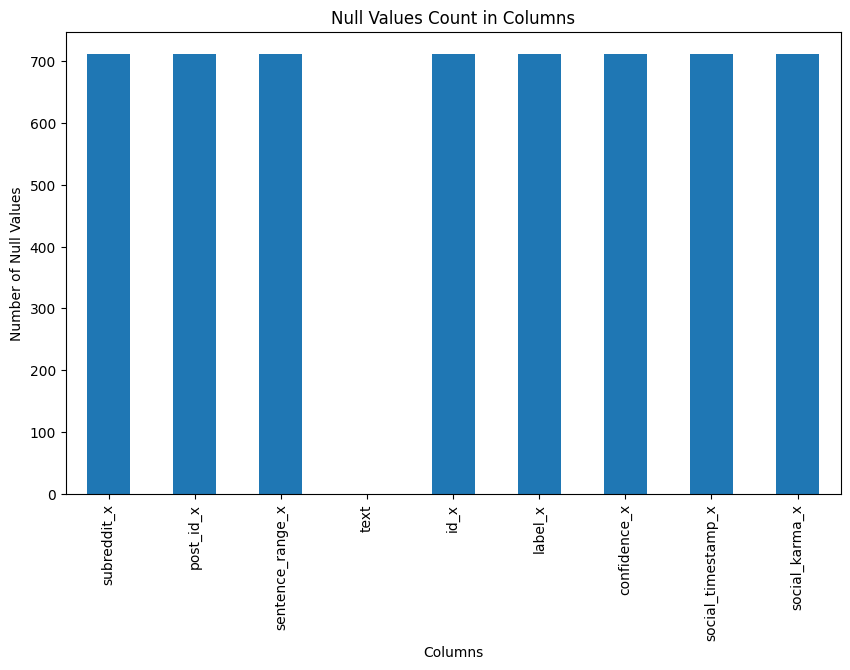

In [ ]:
count_null_values(df_dropped_columns)

In [ ]:
# Function to drop rows with null values
def drop_null_rows(dataframe):
    dataframe = dataframe.dropna()
    return dataframe

cleaned_df = drop_null_rows(df_dropped_columns)
cleaned_df.head()

,subreddit_x,post_id_x,sentence_range_x,text,id_x,label_x,confidence_x,social_timestamp_x,social_karma_x
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181.0,1.0,0.8,1.521614e+09,5.0
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606.0,0.0,1.0,1.527010e+09,4.0
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816.0,1.0,0.8,1.535936e+09,2.0
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239.0,1.0,0.6,1.516430e+09,0.0
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421.0,1.0,0.8,1.539809e+09,24.0


# Saving the file as EXCEL

In [ ]:
import pandas as pd
def save_df_to_csv(df, filename):
    """
    This function saves a pandas DataFrame to a CSV file.

    Args:
    df (pandas.DataFrame): The DataFrame to save.
    filename (str): The name of the CSV file.
    """

    df.to_csv(filename, index=False)


In [ ]:
save_df_to_csv(cleaned_df, 'cleaned_dataset.csv')


# Model 1 - Support Vector Machine
Testing SVM model for semantic analysis

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame and 'text' is the column with text
X = cleaned_df['text']  # social media text data
# 'label' is the column with the labels (mental health condition or not)
y = cleaned_df['subreddit_x']  # label

# Preprocess the labels
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC()),
])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC()),
])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [ ]:
from sklearn.metrics import classification_report

predictions = text_clf.predict(X_test)

print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.33      0.08      0.12        13
           1       0.53      0.62      0.57        99
           2       0.48      0.44      0.46        57
           3       0.38      0.39      0.38        59
           4       0.00      0.00      0.00         8
           5       0.60      0.56      0.58        27
           6       0.51      0.56      0.53       127
           7       0.58      0.73      0.65       113
           8       0.50      0.12      0.20         8
           9       0.22      0.11      0.14        57

    accuracy                           0.50       568
   macro avg       0.41      0.36      0.36       568
weighted avg       0.47      0.50      0.48       568



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Comments/ Considerations
You might want to clean your text data (remove punctuation, stop words, apply stemming or lemmatization) before training the model, and tune the hyperparameters of both the TfidfVectorizer (e.g., use of stop words, n-grams, maximum number of features) and the SVM (e.g., C parameter, class weights, loss function) to get optimal performance.

# BERT NLP model

In [ ]:
from pandas.core.sorting import unique_label_indices
from numpy.ma.extras import unique
# Extract the labels for the number of unique conditions
labels = cleaned_df['subreddit_x'].tolist()
unqiue_labels = unique(labels)
print(unqiue_labels)

['almosthomeless' 'anxiety' 'assistance' 'domesticviolence' 'food_pantry'
 'homeless' 'ptsd' 'relationships' 'stress' 'survivorsofabuse']


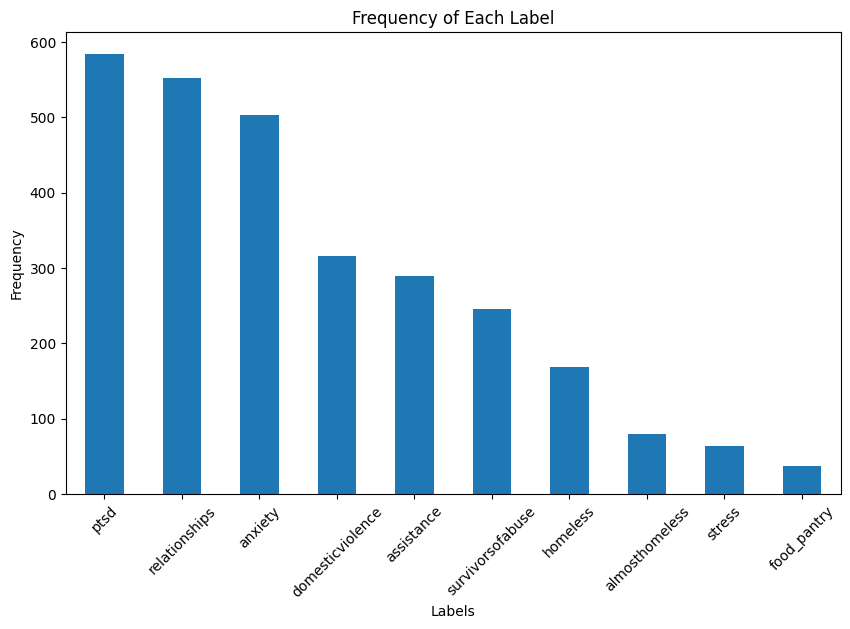

In [ ]:
import matplotlib.pyplot as plt

# Get the frequency of each label
label_freq = cleaned_df['subreddit_x'].value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
label_freq.plot(kind='bar')
plt.title('Frequency of Each Label')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [ ]:
real_labels = ['ptsd', 'relationships', 'anxiety', 'domestic violence', 'assistance', 'survivorsofabuse', 'homeless','almosthomeless', 'stress', 'food_pantry']

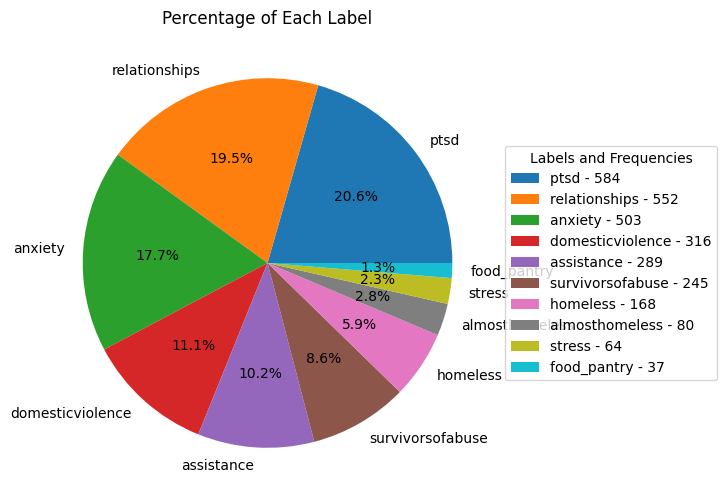

In [ ]:
import matplotlib.pyplot as plt

# Get the frequency of each label
label_freq = cleaned_df['subreddit_x'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(label_freq, labels = label_freq.index, autopct='%1.1f%%')

# Add a legend with frequencies
plt.legend([f'{label} - {freq}' for label, freq in zip(label_freq.index, label_freq)], title="Labels and Frequencies", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Percentage of Each Label')
plt.show()


# Model
BERT, which stands for Bidirectional Encoder Representations from Transformers, is a powerful pre-trained model developed by Google. BERT has caused a significant stir in the NLP (Natural Language Processing) community since its introduction due to its impressive performance across a variety of NLP tasks.

BERT is unique in its use of bidirectional training, which allows it to consider context from both left and right sides of a word during training. Traditional language models, on the other hand, usually examine text input from either left to right (forward direction) or right to left (backward direction). By analyzing context in both directions, BERT is able to understand the meaning of a word based on all of its surroundings.

BERT uses the Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text. As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the Transformer encoder reads the entire sequence of words at once. This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word).

The pre-training process of BERT involves two tasks:

Masked Language Model (MLM): Random words in the sentence are masked (hidden), and the model tries to predict them based on the surrounding context.

Next Sentence Prediction (NSP): The model receives pairs of sentences as input and learns to predict if the second sentence in the pair is the subsequent sentence in the original document.

Once the pre-training process is complete, BERT can be fine-tuned on a specific task using an additional output layer. The fine-tuning process involves feeding the model data from the specific NLP task (such as text from social media posts for sentiment analysis), and training it to make predictions for this task (like identifying the sentiment expressed in a post). During this process, the pre-trained BERT model retains the general language understanding it gained during pre-training but adapts to the specific task at hand.

In the case of predicting sentiment from social media posts:

The input social media post text is first tokenized, i.e., broken down into words or sub-words. These tokens are then fed into the pre-trained BERT model.

BERT transforms these tokens into dense vector representations (also known as embeddings) using the knowledge it gained during pre-training. These embeddings capture deep syntactic and semantic properties of the tokens.

This transformed data is then fed into the fine-tuned layer of BERT, which has been trained on the sentiment prediction task. This layer outputs the sentiment prediction for the input social media post.

The predicted sentiment can then be compared to the true sentiment to assess the model's performance. This comparison can be done using various metrics like accuracy, precision, recall, or F1 score.

Through this process, BERT can accurately predict sentiment from social media posts, even capturing nuanced and complex sentiment due to its understanding of context.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.8 MB/s eta 0:00:00


In [ ]:
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
# import torch
# from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# import numpy as np
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # Specify GPU as device if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load pretrained model and a pretrained tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(labels))
# model = model.to(device)

# # Label Encoding
# encoder = LabelEncoder()
# y = encoder.fit_transform(y)

# # Split into training and validation
# train_text, temp_text, train_labels, temp_labels = train_test_split(X, y, random_state=2018, test_size=0.3)

# # Further split validation set into validation and test
# val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2018, test_size=0.5)

# # Tokenize the text
# train_encodings = tokenizer(list(train_text.values), truncation=True, padding=True)
# val_encodings = tokenizer(list(val_text.values), truncation=True, padding=True)

# # Prepare the data inputs
# train_inputs = torch.tensor(train_encodings['input_ids'])
# train_labels = torch.tensor(train_labels)
# train_masks = torch.tensor(train_encodings['attention_mask'])
# val_inputs = torch.tensor(val_encodings['input_ids'])
# val_labels = torch.tensor(val_labels)
# val_masks = torch.tensor(val_encodings['attention_mask'])

# # Set batch size
# batch_size = 32

# # Number of training epochs
# epochs = 10
# # Create an iterator of our data with torch DataLoader
# train_data = TensorDataset(train_inputs, train_masks, train_labels)
# train_sampler = RandomSampler(train_data)
# train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# val_data = TensorDataset(val_inputs, val_masks, val_labels)
# val_sampler = SequentialSampler(val_data)
# val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# # Set up the optimizer and the learning rate scheduler
# optimizer = AdamW(model.parameters(), lr=2e-5)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

# # Train the model
# model.train()
# for epoch in range(epochs):
#     for step, batch in enumerate(train_dataloader):
#         # Load the batch to the GPU
#         batch = tuple(t.to(device) for t in batch)
#         b_input_ids, b_input_mask, b_labels = batch
#         # Forward pass
#         outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
#         loss = outputs[0]
#         # Backward pass
#         loss.backward()
#         # Update parameters and the learning rate
#         optimizer.step()
#         scheduler.step()

# # Test the model after training
# test_encodings = tokenizer(list(test_text.values), truncation=True, padding=True)
# test_inputs = torch.tensor(test_encodings['input_ids'])
# test_labels = torch.tensor(test_labels)
# test_masks = torch.tensor(test_encodings['attention_mask'])

# # Create the DataLoader for our test set
# test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
# test_sampler = SequentialSampler(test_dataset)
# test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

# # Put model in evaluation mode
# model.eval()

# # Tracking variables
# predictions, true_labels = [], []

# # Predict
# for batch in test_dataloader:
#   batch = tuple(t.to(device) for t in batch)
#   b_input_ids, b_input_mask, b_labels = batch
#   with torch.no_grad():
#     outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
#   logits = outputs[0]
#   logits = logits.detach().cpu().numpy()
#   label_ids = b_labels.to('cpu').numpy()
#   predictions.append(logits)
#   true_labels.append(label_ids)

# # Flatten the predictions and true values for aggregate statistics
# flat_predictions = np.concatenate(predictions, axis=0)
# flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# flat_true_labels = np.concatenate(true_labels, axis=0)

# # Compute the validation accuracy
# val_accuracy = (flat_predictions == flat_true_labels).mean()
# print('Validation Accuracy: ', val_accuracy)
# print('Classification Report: ')
# print(classification_report(flat_true_labels, flat_predictions))


# Tiny BERT

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

 # social media text data
X = cleaned_df['text']
# 'label' is the column with the labels (mental health condition or not)
y = cleaned_df['subreddit_x']  # label

# Specify GPU as device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained model and a pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained('huawei-noah/TinyBERT_General_6L_768D')
model = AutoModelForSequenceClassification.from_pretrained('huawei-noah/TinyBERT_General_6L_768D', num_labels=len(labels))
model = model.to(device)

# Label Encoding
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Split into training and validation
train_text, temp_text, train_labels, temp_labels = train_test_split(X, y, random_state=2018, test_size=0.3)

# Further split validation set into validation and test
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2018, test_size=0.5)

# Tokenize the text
train_encodings = tokenizer(list(train_text.values), truncation=True, padding=True)
val_encodings = tokenizer(list(val_text.values), truncation=True, padding=True)

# Prepare the data inputs
train_inputs = torch.tensor(train_encodings['input_ids'])
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_encodings['attention_mask'])
val_inputs = torch.tensor(val_encodings['input_ids'])
val_labels = torch.tensor(val_labels)
val_masks = torch.tensor(val_encodings['attention_mask'])

# Set batch size
batch_size = 32

# Number of training epochs
epochs = 10

# Create an iterator of our data with torch DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Set up the optimizer and the learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

# Train the model
model.train()
for epoch in range(epochs):
    for step, batch in enumerate(train_dataloader):
        # Load the batch to the GPU
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        # Backward pass
        loss.backward()
        # Update parameters and the learning rate
        optimizer.step()
        scheduler.step()

# Test the model after training
test_encodings = tokenizer(list(test_text.values), truncation=True, padding=True)
test_inputs = torch.tensor(test_encodings['input_ids'])
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_encodings['attention_mask'])

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_labels = [], []

# Predict
for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

# Flatten the predictions and true values for aggregate statistics
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

# Compute the validation accuracy
val_accuracy = (flat_predictions == flat_true_labels).mean()
print('Validation Accuracy: ', val_accuracy)
print('Classification Report: ')
print(classification_report(flat_true_labels, flat_predictions))


Some weights of the model checkpoint at huawei-noah/TinyBERT_General_6L_768D were not used when initializing BertForSequenceClassification: ['fit_denses.0.weight', 'cls.seq_relationship.weight', 'fit_denses.5.bias', 'cls.predictions.transform.dense.bias', 'fit_denses.2.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'fit_denses.1.weight', 'fit_denses.4.weight', 'fit_denses.1.bias', 'fit_denses.6.bias', 'fit_denses.0.bias', 'fit_denses.2.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'fit_denses.5.weight', 'fit_denses.6.weight', 'fit_denses.3.weight', 'fit_denses.3.bias', 'fit_denses.4.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT

Validation Accuracy:  0.19953051643192488
Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        77
           2       0.00      0.00      0.00        44
           3       0.00      0.00      0.00        46
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        28
           6       0.20      1.00      0.33        85
           7       0.00      0.00      0.00        75
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00        43

    accuracy                           0.20       426
   macro avg       0.02      0.10      0.03       426
weighted avg       0.04      0.20      0.07       426



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd

# Data from the classification report
svm_data = {
    'class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'precision': [0.33, 0.53, 0.48, 0.38, 0.00, 0.60, 0.51, 0.58, 0.50, 0.22],
    'recall': [0.08, 0.62, 0.44, 0.39, 0.00, 0.56, 0.56, 0.73, 0.12, 0.11],
    'f1-score': [0.12, 0.57, 0.46, 0.38, 0.00, 0.58, 0.53, 0.65, 0.20, 0.14],
    'support': [13, 99, 57, 59, 8, 27, 127, 113, 8, 57]
}

# Create DataFrame
svm_df = pd.DataFrame(svm_data)

# Print the DataFrame
print(svm_df)


   class  precision  recall  f1-score  support
0      0       0.33    0.08      0.12       13
1      1       0.53    0.62      0.57       99
2      2       0.48    0.44      0.46       57
3      3       0.38    0.39      0.38       59
4      4       0.00    0.00      0.00        8
5      5       0.60    0.56      0.58       27
6      6       0.51    0.56      0.53      127
7      7       0.58    0.73      0.65      113
8      8       0.50    0.12      0.20        8
9      9       0.22    0.11      0.14       57


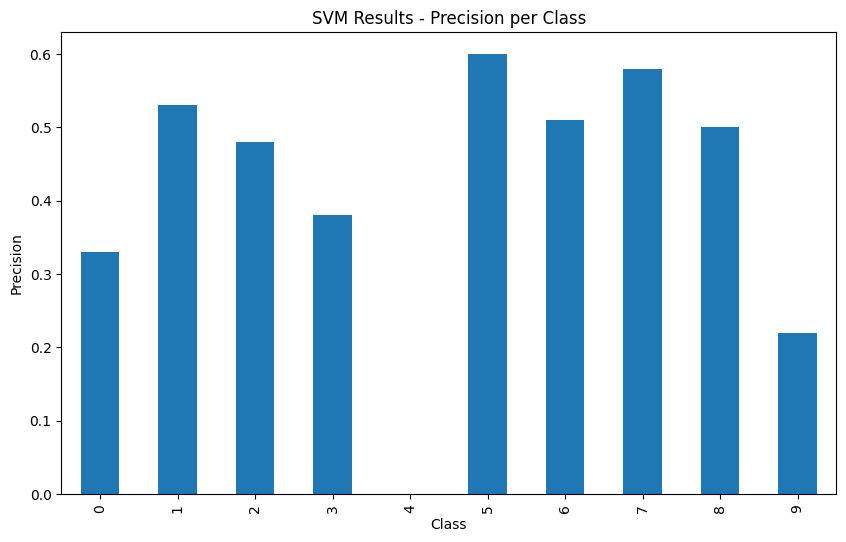

In [ ]:
import matplotlib.pyplot as plt

svm_df.set_index('class')['precision'].plot(kind='bar', figsize=(10, 6))
plt.title('SVM Results - Precision per Class')
plt.ylabel('Precision')
plt.xlabel('Class')

# Save the figure
plt.savefig('svm_results.png')


In [ ]:
# Data from the classification report
tinybert_data = {
    'class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'precision': [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.20, 0.00, 0.00, 0.00],
    'recall': [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00, 0.00],
    'f1-score': [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.33, 0.00, 0.00, 0.00],
    'support': [12, 77, 44, 46, 10, 28, 85, 75, 6, 43]
}

# Create DataFrame
tinybert_df = pd.DataFrame(tinybert_data)

# Print the DataFrame
print(tinybert_df)


   class  precision  recall  f1-score  support
0      0        0.0     0.0      0.00       12
1      1        0.0     0.0      0.00       77
2      2        0.0     0.0      0.00       44
3      3        0.0     0.0      0.00       46
4      4        0.0     0.0      0.00       10
5      5        0.0     0.0      0.00       28
6      6        0.2     1.0      0.33       85
7      7        0.0     0.0      0.00       75
8      8        0.0     0.0      0.00        6
9      9        0.0     0.0      0.00       43


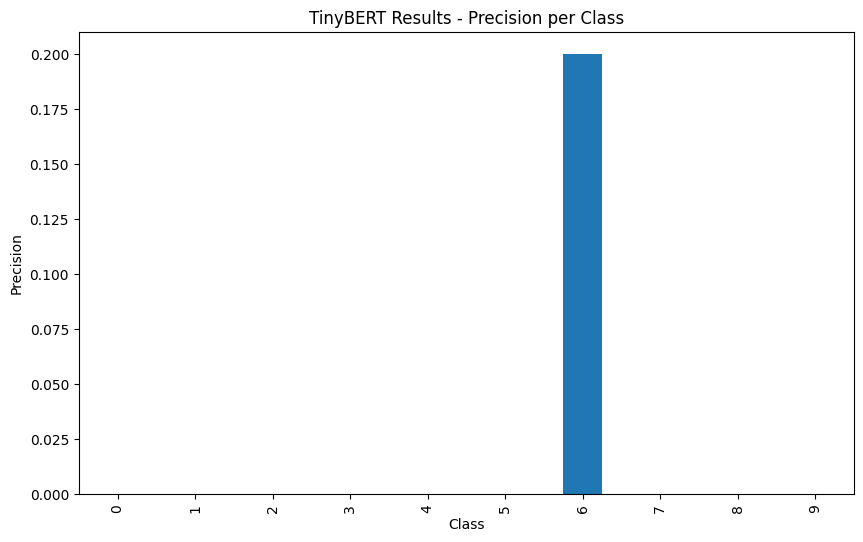

In [ ]:
import matplotlib.pyplot as plt

tinybert_df.set_index('class')['precision'].plot(kind='bar', figsize=(10, 6))
plt.title('TinyBERT Results - Precision per Class')
plt.ylabel('Precision')
plt.xlabel('Class')

# Save the figure
plt.savefig('tinyBERT_results.png')


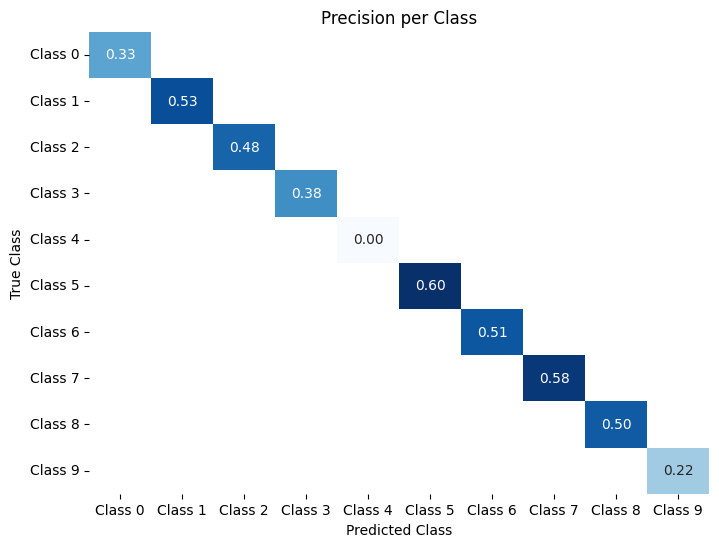

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for the precision values
precision_df = pd.DataFrame({
    'True Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9'],
    'Predicted Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9'],
    'Precision': [0.33, 0.53, 0.48, 0.38, 0.0, 0.6, 0.51, 0.58, 0.5, 0.22]
})

# Reshape the DataFrame for visualization
heatmap_data = precision_df.pivot(index='True Class', columns='Predicted Class', values='Precision')

# Create a heatmap table
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.title('Precision per Class')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Save the figure
plt.savefig('precision_heatmap.png')


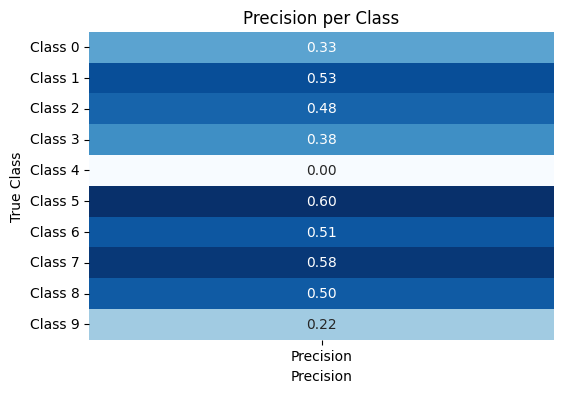

In [ ]:
import pandas as pd
import seaborn as sns

# Create a DataFrame for the precision values
precision_df = pd.DataFrame({
    'True Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9'],
    'Precision': [0.33, 0.53, 0.48, 0.38, 0.0, 0.6, 0.51, 0.58, 0.5, 0.22]
})

# Create a table using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(precision_df.set_index('True Class'), annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.title('Precision per Class')
plt.xlabel('Precision')
plt.ylabel('True Class')

# Save the figure
plt.savefig('precision_table.png')


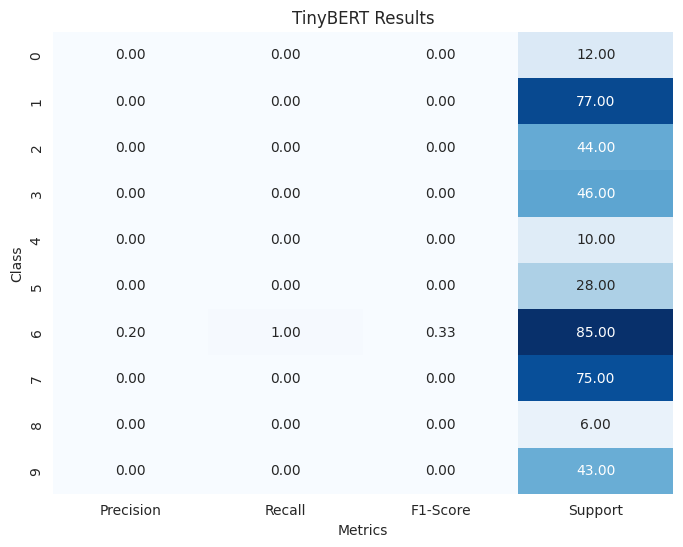

In [ ]:
import pandas as pd
import seaborn as sns

# Create a DataFrame for the TinyBERT results
tinybert_results = pd.DataFrame({
    'Class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'Precision': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0],
    'Recall': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
    'F1-Score': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33, 0.0, 0.0, 0.0],
    'Support': [12, 77, 44, 46, 10, 28, 85, 75, 6, 43]
})

# Create a table using Seaborn
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
ax = sns.heatmap(tinybert_results.set_index('Class'), annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.title('TinyBERT Results')
plt.xlabel('Metrics')
plt.ylabel('Class')

# Save the figure
plt.savefig('tinybert_table.png')


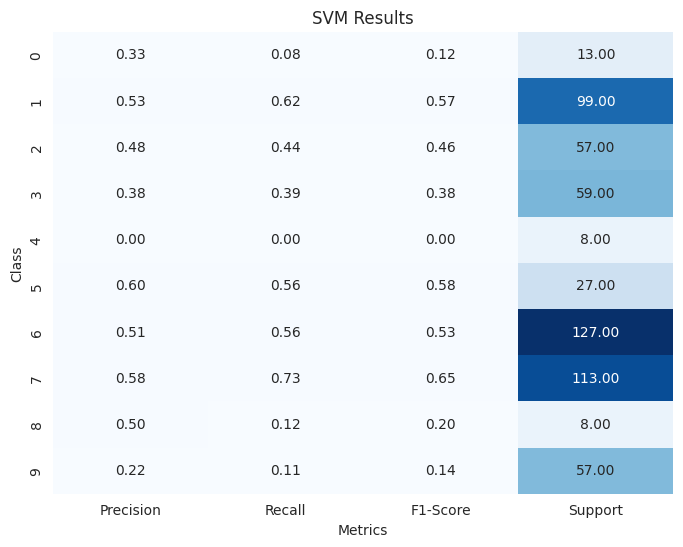

In [ ]:
import pandas as pd
import seaborn as sns

# Create a DataFrame for the SVM results
svm_results = pd.DataFrame({
    'Class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'Precision': [0.33, 0.53, 0.48, 0.38, 0.0, 0.60, 0.51, 0.58, 0.50, 0.22],
    'Recall': [0.08, 0.62, 0.44, 0.39, 0.0, 0.56, 0.56, 0.73, 0.12, 0.11],
    'F1-Score': [0.12, 0.57, 0.46, 0.38, 0.0, 0.58, 0.53, 0.65, 0.20, 0.14],
    'Support': [13, 99, 57, 59, 8, 27, 127, 113, 8, 57]
})

# Create a table using Seaborn
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
ax = sns.heatmap(svm_results.set_index('Class'), annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.title('SVM Results')
plt.xlabel('Metrics')
plt.ylabel('Class')

# Save the figure
plt.savefig('svm_table.png')


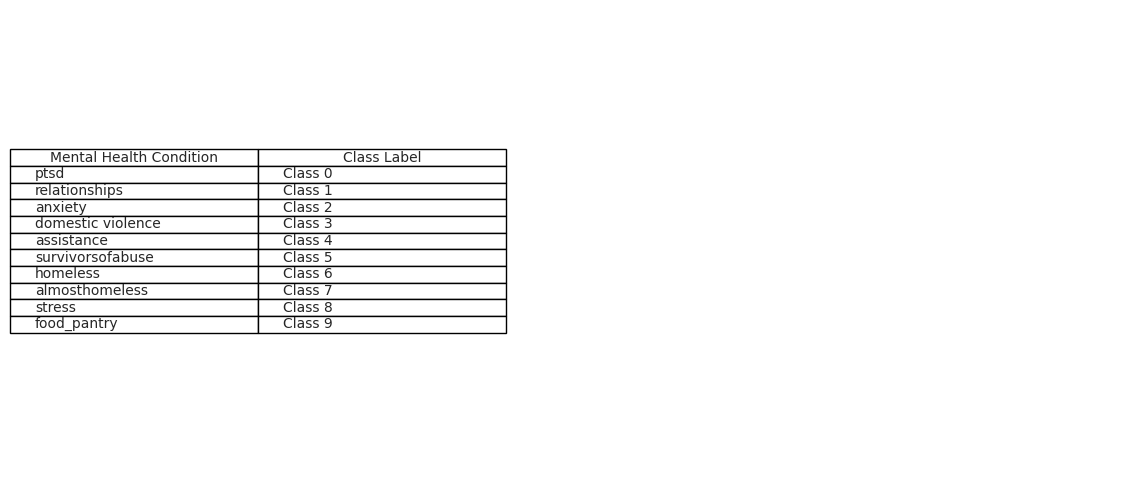

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

mental_health = ['ptsd', 'relationships', 'anxiety', 'domestic violence', 'assistance', 'survivorsofabuse', 'homeless', 'almosthomeless', 'stress', 'food_pantry']
class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']

df_key = pd.DataFrame({'Mental Health Condition': mental_health, 'Class Label': class_labels})

# Plotting the table as a figure
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')  # Turn off the axis
ax.table(cellText=df_key.values, colLabels=df_key.columns, loc='left', cellLoc='left', colWidths=[0.4, 0.4])

# Saving the figure as a PNG image
plt.savefig('key_table.png', bbox_inches='tight', pad_inches=0.5, dpi=300)


In [67]:
!pip3 install graphviz
!pip install cgraph
!pip3 install pygraphviz


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for cgraph: filename=cGraph-0.1-cp310-cp310-linux_x86_64.whl size=19654 sha256=489ce80de2e0aa30ce1581bc9205d51b58160123c6b1d4e8e11dc242ec5c547c
  Stored in directory: /root/.cache/pip/wheels/82/b2/ae/2640d2c72b55343d87966eb775d25e916742f94aefb0c0f298
Successfully built cgraph
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pygraphviz-1.11.zip (120 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pygraphviz
  Ru

In [68]:
import graphviz

# Create a new Digraph
graph = graphviz.Digraph(format='png')

# Define the nodes for each step in the NLTK workflow
nodes = [
    ('Load Corpus', {}),
    ('Tokenization', {}),
    ('Stopword Removal', {}),
    ('Stemming/Lemmatization', {}),
    ('POS Tagging', {}),
    ('Chunking', {}),
    ('Named Entity Recognition', {}),
    ('Sentiment Analysis', {})
]

# Add nodes to the graph
for node, attrs in nodes:
    graph.node(node, **attrs)

# Define the edges to connect the nodes in the workflow
edges = [
    ('Load Corpus', 'Tokenization'),
    ('Tokenization', 'Stopword Removal'),
    ('Stopword Removal', 'Stemming/Lemmatization'),
    ('Stemming/Lemmatization', 'POS Tagging'),
    ('POS Tagging', 'Chunking'),
    ('Chunking', 'Named Entity Recognition'),
    ('Named Entity Recognition', 'Sentiment Analysis')
]

# Add edges to the graph
for edge in edges:
    graph.edge(*edge)

# Render the graph to a file
graph.render('nltk_workflow', view=True)


'nltk_workflow.png'

In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

# Assuming cleaned_df is your DataFrame
X = cleaned_df['text']  # social media text data
y = cleaned_df['subreddit_x']  # label

# Step 1 and 2: Dependency Parsing and Logical Analysis
# These steps usually require more sophisticated NLP libraries like SpaCy or StanfordNLP.
# For simplicity, let's skip these steps for this basic sentiment analysis model.

# Step 3: Semantic Annotation
# Similarly, semantic annotation usually needs more advanced techniques and it's not typically used in a basic sentiment analysis.
# We'll also skip this one for this example.

# Step 4: Natural Language Tokenization
# Tokenize the text using NLTK's word_tokenize function
X_tokenized = X.apply(word_tokenize)

# Convert list of words back to string
X_tokenized = X_tokenized.str.join(' ')

# Create a TF-IDF Vectorizer object
vectorizer = TfidfVectorizer()

# Fit and transform the tokenized text data
X_vectorized = vectorizer.fit_transform(X_tokenized)

# Step 5: Classification
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Create a Logistic Regression classifier object
clf = LogisticRegression()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                  precision    recall  f1-score   support

  almosthomeless       0.00      0.00      0.00        13
         anxiety       0.54      0.65      0.59        99
      assistance       0.62      0.40      0.49        57
domesticviolence       0.44      0.36      0.39        59
     food_pantry       0.00      0.00      0.00         8
        homeless       0.71      0.19      0.29        27
            ptsd       0.40      0.65      0.50       127
   relationships       0.57      0.76      0.65       113
          stress       0.00      0.00      0.00         8
survivorsofabuse       0.50      0.04      0.07        57

        accuracy                           0.50       568
       macro avg       0.38      0.30      0.30       568
    weighted avg       0.49      0.50      0.45       568



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
import pandas as pd
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

# Load the SpaCy model
nlp = spacy.load('en_core_web_sm')

# Assuming cleaned_df is your DataFrame
X = cleaned_df['text']  # social media text data
y = cleaned_df['subreddit_x']  # label

# Step 1: Dependency Parsing
# Parse the text using the SpaCy model to get a Doc object for each text in the dataset
X_parsed = X.apply(nlp)

# Step 2: Logical Analysis
# Here, we will extract simple features from the parsed data, such as the lemma of the word,
# whether it is a stop word, its POS tag, and whether it is alphanumeric
def extract_features(doc):
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha and token.pos_ != 'PUNCT'])

X_feature_extracted = X_parsed.apply(extract_features)

# Step 3: Semantic Annotation
# Similarly, semantic annotation usually needs more advanced techniques and it's not typically used in a basic sentiment analysis.
# We'll also skip this one for this example.

# Step 4: Natural Language Tokenization
# Tokenize the text using NLTK's word_tokenize function
X_tokenized = X_feature_extracted.apply(word_tokenize)

# Convert list of words back to string
X_tokenized = X_tokenized.str.join(' ')

# Create a TF-IDF Vectorizer object
vectorizer = TfidfVectorizer()

# Fit and transform the tokenized text data
X_vectorized = vectorizer.fit_transform(X_tokenized)

# Step 5: Classification
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Create a Logistic Regression classifier object
clf = LogisticRegression()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                  precision    recall  f1-score   support

  almosthomeless       0.00      0.00      0.00        13
         anxiety       0.57      0.64      0.60        99
      assistance       0.59      0.42      0.49        57
domesticviolence       0.47      0.32      0.38        59
     food_pantry       0.00      0.00      0.00         8
        homeless       0.73      0.30      0.42        27
            ptsd       0.41      0.69      0.51       127
   relationships       0.52      0.69      0.60       113
          stress       0.00      0.00      0.00         8
survivorsofabuse       0.75      0.05      0.10        57

        accuracy                           0.50       568
       macro avg       0.40      0.31      0.31       568
    weighted avg       0.51      0.50      0.46       568



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
import pandas as pd
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
import nltk

nltk.download('punkt')
nltk.download('wordnet')

# Load the SpaCy model
nlp = spacy.load('en_core_web_sm')

# Assuming cleaned_df is your DataFrame
X = cleaned_df['text']  # social media text data
y = cleaned_df['subreddit_x']  # label

# Step 1: Dependency Parsing
# Parse the text using the SpaCy model to get a Doc object for each text in the dataset
X_parsed = X.apply(nlp)

# Step 2: Logical Analysis
# Extract simple features from the parsed data
def extract_features(doc):
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha and token.pos_ != 'PUNCT'])

X_feature_extracted = X_parsed.apply(extract_features)

# Step 3: Semantic Annotation
# Add synonyms and antonyms of the words to the text
def semantic_augmentation(text):
    words = text.split()
    augmented_text = []
    for word in words:
        syns = wn.synsets(word)
        if syns:
            # Add the first synonym if it exists
            lemmas = syns[0].lemmas()
            if lemmas:
                augmented_text.append(lemmas[0].name())
            # Add the first antonym if it exists
            if lemmas and lemmas[0].antonyms():
                augmented_text.append(lemmas[0].antonyms()[0].name())
        augmented_text.append(word)
    return ' '.join(augmented_text)

X_augmented = X_feature_extracted.apply(semantic_augmentation)

# Step 4: Natural Language Tokenization
# Tokenize the text using NLTK's word_tokenize function
X_tokenized = X_augmented.apply(word_tokenize)

# Convert list of words back to string
X_tokenized = X_tokenized.str.join(' ')

# Create a TF-IDF Vectorizer object
vectorizer = TfidfVectorizer()

# Fit and transform the tokenized text data
X_vectorized = vectorizer.fit_transform(X_tokenized)

# Step 5: Classification
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Create a Logistic Regression classifier object
clf = LogisticRegression()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


                  precision    recall  f1-score   support

  almosthomeless       0.00      0.00      0.00        13
         anxiety       0.56      0.63      0.59        99
      assistance       0.55      0.40      0.46        57
domesticviolence       0.49      0.32      0.39        59
     food_pantry       0.00      0.00      0.00         8
        homeless       0.82      0.33      0.47        27
            ptsd       0.42      0.67      0.51       127
   relationships       0.53      0.73      0.61       113
          stress       0.00      0.00      0.00         8
survivorsofabuse       0.60      0.05      0.10        57

        accuracy                           0.50       568
       macro avg       0.40      0.31      0.31       568
    weighted avg       0.50      0.50      0.46       568



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
import pandas as pd

# Create a dataframe from your data
data = {
    'Category': ['almosthomeless', 'anxiety', 'assistance', 'domesticviolence', 'food_pantry', 'homeless', 'ptsd', 'relationships', 'stress', 'survivorsofabuse'],
    'Precision': [0.00, 0.57, 0.59, 0.47, 0.00, 0.73, 0.41, 0.52, 0.00, 0.75],
    'Recall': [0.00, 0.64, 0.42, 0.32, 0.00, 0.30, 0.69, 0.69, 0.00, 0.05],
    'F1-score': [0.00, 0.60, 0.49, 0.38, 0.00, 0.42, 0.51, 0.60, 0.00, 0.10],
    'Support': [13, 99, 57, 59, 8, 27, 127, 113, 8, 57]
}

df = pd.DataFrame(data)

# Save the dataframe to a CSV file
df.to_csv('classification_report.csv', index=False)


In [78]:
# workaround
import locale
locale.getpreferredencoding()
locale.getpreferredencoding = lambda: "UTF-8"
!pip install "dataframe-image"


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.0 MB/s eta 0:00:00


In [80]:
import pandas as pd
import dataframe_image as dfi

# Define the classification data
data = {
    'Category': ['almosthomeless', 'anxiety', 'assistance', 'domesticviolence', 'food_pantry', 'homeless', 'ptsd', 'relationships', 'stress', 'survivorsofabuse'],
    'Precision': [0.00, 0.57, 0.59, 0.47, 0.00, 0.73, 0.41, 0.52, 0.00, 0.75],
    'Recall': [0.00, 0.64, 0.42, 0.32, 0.00, 0.30, 0.69, 0.69, 0.00, 0.05],
    'F1-score': [0.00, 0.60, 0.49, 0.38, 0.00, 0.42, 0.51, 0.60, 0.00, 0.10],
    'Support': [13, 99, 57, 59, 8, 27, 127, 113, 8, 57]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)




OSError: ignored

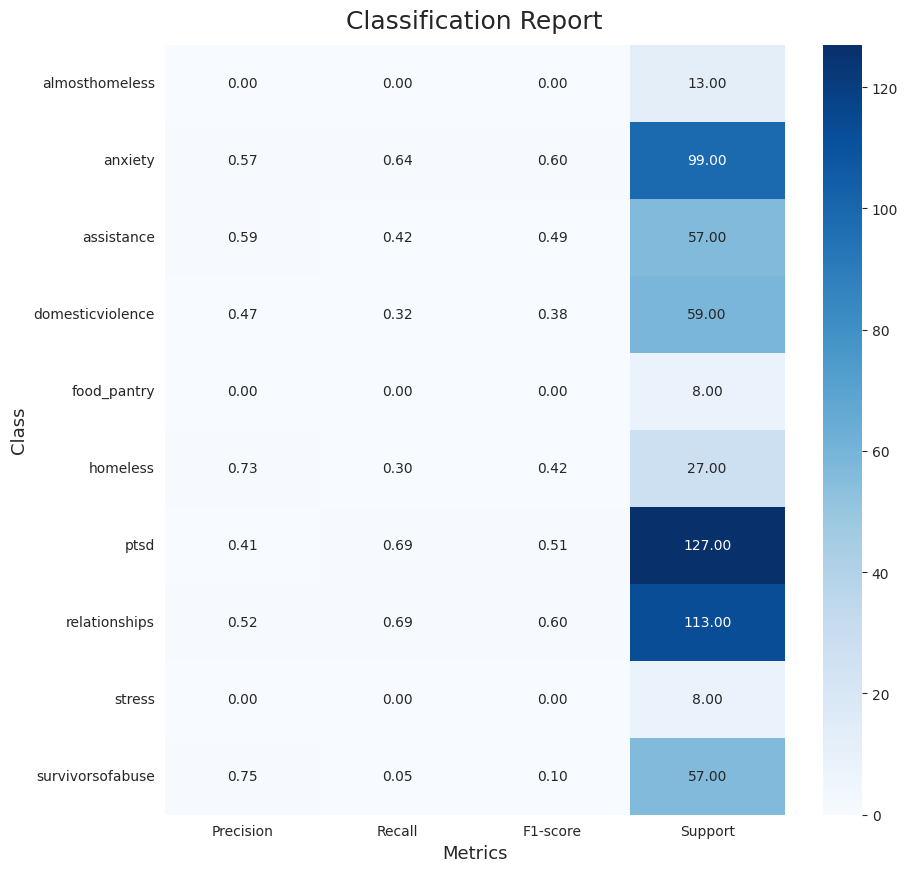

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the classification data
data = {
    'Class': ['almosthomeless', 'anxiety', 'assistance', 'domesticviolence', 'food_pantry', 'homeless', 'ptsd', 'relationships', 'stress', 'survivorsofabuse'],
    'Precision': [0.00, 0.57, 0.59, 0.47, 0.00, 0.73, 0.41, 0.52, 0.00, 0.75],
    'Recall': [0.00, 0.64, 0.42, 0.32, 0.00, 0.30, 0.69, 0.69, 0.00, 0.05],
    'F1-score': [0.00, 0.60, 0.49, 0.38, 0.00, 0.42, 0.51, 0.60, 0.00, 0.10],
    'Support': [13, 99, 57, 59, 8, 27, 127, 113, 8, 57]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Set the style of the heatmap
sns.set_style("whitegrid")

# Create the heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(df.set_index('Class'), annot=True, cmap='Blues', fmt='.2f', cbar=True)

# Set the title and labels of the heatmap
heatmap.set_title('Classification Report', fontdict={'fontsize':18}, pad=12)
heatmap.set_xlabel('Metrics', fontsize=13)
heatmap.set_ylabel('Class', fontsize=13)

# Save the heatmap as a .png file
plt.savefig('classification_report.png')
